# The Roboat Environmental Data API Wrapper

The following is a very, very small intro into the Roboat environmental API wrapper. It should give you a good idea of what is possible and will be completely documented in due time.

In the near future, the wrapper will be updated with object functionality to make everything super fluid - in the mean time, we can get by with this simple API wrapper with somewhat limited functionality and little documentation...


## Authentication

To get started, you must first request an API Key. You can do so at https://www.roboat-enviro.com/api-keys. Once you have your API key, store it as an environment variable called *ROBOAT-ENVIRO_APIKEY*.

In [30]:
import json
from pprint import pprint
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.collections import PolyCollection
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors

In [2]:
import roboatenviro
print ("roboatenviro v{}".format(roboatenviro.__version__))

roboatenviro v0.1.0


## Advanced Queries

The API itself has quite powerful querying capabilites, though they can be a bit confusing to use at first. Eventually, I will get around to writing a "helper" function to make this as simple as possible.

### Limit

To limit the number of results you get for queries where a list of information is returned, you can add the `limit` keyword to your `params` dictionary. The argument must be an integer (i.e. `limit=5`.)

Example:

Return the first five sensors in the list:

    >>> api.get_sensors(params=dict(limit=5))
    
### Sort

You can sort the order of results by any column and either by `asc` or `desc`. The format for the `sort` keyword must be `sort="[column],[asc or desc]"`. You can also join multiple sorts together using a semicolon.

Example:

Return the first five sensors, sorted asc by the last seen column:

    >>> api.get_sensors(params=dict(limit=5, sort="last_seen,asc"))
    
  
Return the first five sensors, sorted asc by last_seen and asc by username:

    >>> api.get_sensors(params=dict(limit=5, sort="last_seen,asc;username,asc"))
    

### Filter

Filter is probably the most useful because it allows you to grab data between certain timestamps! There is also a ton of embedded functionality built in. The arguments that can be used include:

  * `eq`: equals
  * `ne`: not equals
  * `lt`: less than
  * `le`: less than or equal to
  * `gt`: greater than
  * `ge`: greater than or equal to
  * `in`: in
  * `like`: like
  
The format to the argument is as follows: `filter="[column],[arg],[value]"`. 

Examples:

Grab data between May 1st and June 1st, 2018.

    >>> api.get_trf_data(sn="SN001", params=dict(filter="timestamp,ge,2018-05-01;timestamp,lt,2018-06-01"))


## Initialize a RoboatEnviro object

To start, we will first setup an object of the manager, called `roboatenviro.RoboatEnviro`. If you haven't stored your api key as an environment variable, or have called it something else, feel free to enter it here.

In [6]:
import os
# get the token from a different environment variable
#token = os.getenv("ROBOAT-ENVIRO_APIKEY_DEV")

#hardcoded in here for now...
token = "token"

# set up the roboatenviro.RoboatEnviro object
# here, we are also going to manually set the endpoint because I am doing this tutorial on 
# localhost...
#api = roboatenviro.RoboatEnviro(token=token, endpoint="http://localhost:5000/api/")
api = roboatenviro.RoboatEnviro(token=token, endpoint="https://roboat-enviro.herokuapp.com/api/")

## `roboatenviro.RoboatEnviro(*args, **kwargs)`

The RoboatEnviro (can also be called the 'manager') object provides a simple way to view information about all the sensors you have access to with your account. Remember, the API key is tied to your account, so don't share the key with anyone!  Please keep it safe and sound.

Below, I will detail a few of the methods available from the manager:

### `roboatenviro.legacy.RoboatEnviro.get_users(return_type='json')`

The `get_account` method simply retrieves the account information tied to your API key as a dictionary.

In [7]:
api.get_users(return_type='dataframe')
#api.add_user() #TODO
#api.update_user() #TODO
#api.delete_user("drew")

https://roboat-enviro.herokuapp.com/api/v1/users token GET
<Response [200]>


""


### `roboatenviro.RoboatEnviro.add_sensor(**kwargs)`

Use this method to add a sensor to the db.

In [8]:
display(api.get_sensors())
api.add_sensor(params=dict(sn="SN001"))

https://roboat-enviro.herokuapp.com/api/v1/sensors token GET
<Response [200]>


[]

https://roboat-enviro.herokuapp.com/api/v1/sensors/ token POST


<Response [201]>

### `roboatenviro.RoboatEnviro.get_sensors(return_type='json', **kwargs)`

With the `get_sensors` method, we can retrieve all the sensors we have access to. You can return them either as 'json' or 'dataframe'.

#### json

In [9]:
api.get_sensors()

https://roboat-enviro.herokuapp.com/api/v1/sensors token GET
<Response [200]>


[{'created_at': 'Tue, 04 Feb 2020 14:28:31 GMT', 'id': 1, 'sn': 'SN001'}]

#### dataframe

In [10]:
api.get_sensors(return_type='dataframe')

https://roboat-enviro.herokuapp.com/api/v1/sensors token GET
<Response [200]>


,created_at,id,sn
0,"Tue, 04 Feb 2020 14:28:31 GMT",1,SN001


You should also be able to send whatever query params you want as keywords - see above in the "Advanced Queries" section for more information.

In [11]:
api.get_sensors(return_type='dataframe', params=dict(limit=1))

https://roboat-enviro.herokuapp.com/api/v1/sensors token GET
<Response [200]>


,created_at,id,sn
0,"Tue, 04 Feb 2020 14:28:31 GMT",1,SN001


### `roboatenviro.RoboatEnviro.get_sensor(sn)`

You can get a single sensor, by using this method.

In [12]:
api.get_sensor(sn="SN001")

https://roboat-enviro.herokuapp.com/api/v1/sensors/SN001 token GET
<Response [200]>


{'created_at': '2020-02-04T14:28:31.618347',
 'id': 1,
 'modified_at': '2020-02-04T14:28:31.618370',
 'sn': 'SN001'}

### `roboatenviro.RoboatEnviro.update_sensor(sn, params)`

Use this method to update a sensor with params as a dictionary.

In [13]:
#params = dict(lat=12.1, lon=-100)
params = dict(sn="SN002")
api.update_sensor("SN001", params=params)
params = dict(sn="SN001")
api.update_sensor("SN002", params=params)

https://roboat-enviro.herokuapp.com/api/v1/sensors/SN001 token PUT
<Response [200]>
https://roboat-enviro.herokuapp.com/api/v1/sensors/SN002 token PUT
<Response [200]>


{'created_at': '2020-02-04T14:28:31.618347',
 'id': 1,
 'modified_at': '2020-02-04T14:28:35.844209',
 'sn': 'SN001'}

### `roboatenviro.RoboatEnviro.delete_sensor(sn, params)`

Use this method to delete a sensor (CAUTION: deletion cascades to all related tables).

In [27]:
#api.delete_sensor(sn="SN001")

### `roboatenviro.RoboatEnviro.get_deployments(return_type="json", **kwargs)`

Use this method to retrieve a list of deployments.

In [28]:
params = {
    "name": "Test deployment",
    "start_datetime": datetime.utcnow().isoformat(),
    "end_datetime": (datetime.utcnow() + timedelta(days=1)).isoformat(),
    "summary": "Just a test"
}
#api.add_deployment(params=params)
#api.add_deployment_sensors(param=params)
api.get_deployments(return_type='dataframe')
#api.get_deployment_sensors(return_type='dataframe')

http://localhost:5000/api/v1/deployments token GET
<Response [200]>


""


In [29]:
#api.delete_deployment()

### `roboatenviro.RoboatEnviro.add_sensor_log(**kwargs)`

Use this method to add a sensor log.

### `roboatenviro.RoboatEnviro.get_sensor_logs(return_type="json", **kwargs)`

Use this method to retrieve a list of sensor logs.

In [30]:
params = {
    "sensor_sn": "SN001",
    "log_datetime": datetime.utcnow().isoformat(),
    "log": "test log",
    "priority": "LOW"
}
api.add_sensor_log(params=params)
api.get_sensor_logs(return_type='dataframe')
#api.delete_sensor_log() #TODO

http://localhost:5000/api/v1/sensor-logs/ token POST
http://localhost:5000/api/v1/sensor-logs token GET
<Response [200]>


,id,log,log_datetime,priority,sensor_sn
0,1,test log,"Mon, 03 Feb 2020 18:31:14 GMT",LOW,SN001
1,2,test log,"Mon, 03 Feb 2020 18:33:49 GMT",LOW,SN001
2,3,test log,"Mon, 03 Feb 2020 18:37:07 GMT",LOW,SN001


### `roboatenviro.RoboatEnviro.add_sensor_metadata(**kwargs)`

Use this method to add sensor metadata.

### `roboatenviro.RoboatEnviro.get_sensor_metadata(return_type="json", **kwargs)`

Use this method to retrieve a list of sensor metadata.

In [31]:
params = {
    "sensor_sn": "SN001",
    "metadata_datetime": datetime.utcnow().isoformat(),
    "sensor_metadata": "test metadata",
}
api.add_sensor_metadata(params=params)
api.get_sensor_metadata(return_type='dataframe')
#api.delete_sensor_metadata() #TODO

http://localhost:5000/api/v1/sensor-metadata/ token POST
http://localhost:5000/api/v1/sensor-metadata token GET
<Response [200]>


,id,metadata_datetime,sensor_metadata,sensor_sn
0,1,"Mon, 03 Feb 2020 18:31:15 GMT",test metadata,SN001
1,2,"Mon, 03 Feb 2020 18:33:50 GMT",test metadata,SN001
2,3,"Mon, 03 Feb 2020 18:37:08 GMT",test metadata,SN001


### `roboatenviro.RoboatEnviro.add_trf_scan_set(**kwargs)`

Use this method to add a TRF scan set to the db.

In [23]:
df = pd.read_csv("trf_upload.csv")
df["scan_datetime"] = datetime.utcnow().isoformat()
df.drop(["sensor_sn"], axis=1, inplace=True)
params = {
    "sensor_sn": "SN001",
    "start_datetime": df["scan_datetime"].min(),
    "end_datetime": df["scan_datetime"].max(),
    "start_wl": int(df["mcr_wl"].min()),
    "end_wl": int(df["mcr_wl"].max()),
    "pico_trig_channel": "Aux",
    "pico_trig_thresh": 0,
    "pico_trig_dir": 0,
    "pico_trig_delay": 0,
    "pico_autotrig_timeout": 0,
    "pico_pre_trig_samples": 0,
    "pico_post_trig_samples": 0,
    "pico_sampling_channel": "A",
    "pico_coupling_type": 0,
    "pico_voltage_range": 0,
    "pico_analog_offset": 0,
    "pico_bandwidth_limiter": 0, 
    "pico_num_blocks": 0,
    "pico_timebase": 0,
    "mcr_serial_num": "test",
    "mcr_grating": 0,
    "mcr_units": "um",
}
scan_set = api.add_trf_scan_set(params=params)
scan_set = json.loads(scan_set.text)
scan_set_id = scan_set['id']
print("scan_set_id: ", scan_set_id)
df['scan_set_id'] = scan_set_id
display(df.head())

https://roboat-enviro.herokuapp.com/api/v1/trf-scan-sets/ token POST
scan_set_id:  9


,mcr_wl,trf_scan,scan_datetime,scan_set_id
0,325,"[0.04500000000000052, 0.04500000000000052, 0.0...",2020-02-04T14:44:31.366349,9
1,326,"[0.04500000000000052, 0.04500000000000052, 0.0...",2020-02-04T14:44:31.366349,9
2,327,"[0.04500000000000052, 0.04500000000000052, 0.0...",2020-02-04T14:44:31.366349,9
3,328,"[0.04500000000000052, 0.04500000000000052, 0.0...",2020-02-04T14:44:31.366349,9
4,329,"[0.04500000000000052, 0.04500000000000052, 0.0...",2020-02-04T14:44:31.366349,9


### `roboatenviro.RoboatEnviro.get_trf_scan_set(sn, return_type="json", final_data=True, **kwargs)`

Use this method to retrieve a list of TRF scan sets for a given SN.

In [111]:
display(api.get_trf_scan_set("SN001", return_type="dataframe"))

https://roboat-enviro.herokuapp.com/api/v1/trf-scan-sets/ token GET
<Response [200]>


,end_datetime,end_wl,id,mcr_grating,mcr_serial_num,mcr_units,pico_analog_offset,pico_autotrig_timeout,pico_bandwidth_limiter,pico_coupling_type,...,pico_sampling_channel,pico_timebase,pico_trig_channel,pico_trig_delay,pico_trig_dir,pico_trig_thresh,pico_voltage_range,sensor_sn,start_datetime,start_wl
0,"Tue, 04 Feb 2020 14:29:01 GMT",268,5,1,23721,Nanometers,0,0,0,2,...,A,0,Aux,0,2,64,5,SN001,"Tue, 04 Feb 2020 14:29:01 GMT",266
1,"Tue, 04 Feb 2020 14:30:32 GMT",366,6,1,23721,Nanometers,0,0,0,2,...,A,0,Aux,0,2,64,5,SN001,"Tue, 04 Feb 2020 14:30:20 GMT",166
2,"Tue, 04 Feb 2020 14:42:48 GMT",366,7,1,23721,Nanometers,0,0,0,2,...,A,0,Aux,0,2,64,5,SN001,"Tue, 04 Feb 2020 14:42:37 GMT",166
3,"Tue, 04 Feb 2020 14:43:27 GMT",270,8,1,23721,Nanometers,0,0,0,2,...,A,0,Aux,0,2,64,5,SN001,"Tue, 04 Feb 2020 14:43:27 GMT",266
4,"Tue, 04 Feb 2020 14:44:31 GMT",350,9,0,test,um,0,0,0,0,...,A,0,Aux,0,0,0,0,SN001,"Tue, 04 Feb 2020 14:44:31 GMT",325
5,"Tue, 04 Feb 2020 14:47:36 GMT",270,10,1,23721,Nanometers,0,0,0,2,...,A,0,Aux,0,2,64,5,SN001,"Tue, 04 Feb 2020 14:47:36 GMT",266
6,"Tue, 04 Feb 2020 14:48:03 GMT",270,11,1,23721,Nanometers,0,0,0,2,...,A,0,Aux,0,2,64,5,SN001,"Tue, 04 Feb 2020 14:48:03 GMT",266
7,"Tue, 04 Feb 2020 15:12:31 GMT",366,12,1,23721,Nanometers,0,0,0,2,...,A,0,Aux,0,2,64,5,SN001,"Tue, 04 Feb 2020 15:12:19 GMT",166
8,"Tue, 04 Feb 2020 15:15:55 GMT",366,13,1,23721,Nanometers,0,0,0,2,...,A,0,Aux,0,2,64,5,SN001,"Tue, 04 Feb 2020 15:15:43 GMT",166
9,"Tue, 04 Feb 2020 15:17:07 GMT",270,14,1,23721,Nanometers,0,0,0,2,...,A,0,Aux,0,2,64,5,SN001,"Tue, 04 Feb 2020 15:17:07 GMT",266


### `roboatenviro.RoboatEnviro.add_trf_data(**kwargs)`

Use this method to add a TRF scans to the db.

In [24]:
for idx, row in df.iterrows():
    params = row.to_dict()
    api.add_trf_data(params=params)

{'mcr_wl': 325,
 'scan_datetime': '2020-02-04T14:44:31.366349',
 'scan_set_id': 9,
 'trf_scan': '[0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.0, 0.04500000000000052, 0.09100000000000062, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.0, 0.0, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.09100000000000062, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.09100000000000062, 0.04500000000000052, 0.04500000000000052, 0.09100000000000062, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.045

{'mcr_wl': 326,
 'scan_datetime': '2020-02-04T14:44:31.366349',
 'scan_set_id': 9,
 'trf_scan': '[0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.0, 0.04500000000000052, 0.09100000000000062, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.0, 0.0, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.09100000000000062, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.09100000000000062, 0.04500000000000052, 0.04500000000000052, 0.09100000000000062, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.045

{'mcr_wl': 327,
 'scan_datetime': '2020-02-04T14:44:31.366349',
 'scan_set_id': 9,
 'trf_scan': '[0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.0, 0.04500000000000052, 0.09100000000000062, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.0, 0.0, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.09100000000000062, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.09100000000000062, 0.04500000000000052, 0.04500000000000052, 0.09100000000000062, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.045

{'mcr_wl': 328,
 'scan_datetime': '2020-02-04T14:44:31.366349',
 'scan_set_id': 9,
 'trf_scan': '[0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.0, 0.04500000000000052, 0.09100000000000062, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.0, 0.0, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.09100000000000062, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.09100000000000062, 0.04500000000000052, 0.04500000000000052, 0.09100000000000062, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.045

{'mcr_wl': 329,
 'scan_datetime': '2020-02-04T14:44:31.366349',
 'scan_set_id': 9,
 'trf_scan': '[0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.0, 0.04500000000000052, 0.09100000000000062, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.0, 0.0, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.09100000000000062, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.09100000000000062, 0.04500000000000052, 0.04500000000000052, 0.09100000000000062, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.045

{'mcr_wl': 330,
 'scan_datetime': '2020-02-04T14:44:31.366349',
 'scan_set_id': 9,
 'trf_scan': '[0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.0, 0.04500000000000052, 0.09100000000000062, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.0, 0.0, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.09100000000000062, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.09100000000000062, 0.04500000000000052, 0.04500000000000052, 0.09100000000000062, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.045

{'mcr_wl': 331,
 'scan_datetime': '2020-02-04T14:44:31.366349',
 'scan_set_id': 9,
 'trf_scan': '[0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.0, 0.04500000000000052, 0.09100000000000062, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.0, 0.0, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.09100000000000062, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.09100000000000062, 0.04500000000000052, 0.04500000000000052, 0.09100000000000062, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.045

{'mcr_wl': 332,
 'scan_datetime': '2020-02-04T14:44:31.366349',
 'scan_set_id': 9,
 'trf_scan': '[0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.0, 0.04500000000000052, 0.09100000000000062, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.0, 0.0, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.09100000000000062, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.09100000000000062, 0.04500000000000052, 0.04500000000000052, 0.09100000000000062, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.045

{'mcr_wl': 333,
 'scan_datetime': '2020-02-04T14:44:31.366349',
 'scan_set_id': 9,
 'trf_scan': '[0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.0, 0.04500000000000052, 0.09100000000000062, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.0, 0.0, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.09100000000000062, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.09100000000000062, 0.04500000000000052, 0.04500000000000052, 0.09100000000000062, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.045

{'mcr_wl': 334,
 'scan_datetime': '2020-02-04T14:44:31.366349',
 'scan_set_id': 9,
 'trf_scan': '[0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.0, 0.04500000000000052, 0.09100000000000062, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.0, 0.0, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.09100000000000062, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.09100000000000062, 0.04500000000000052, 0.04500000000000052, 0.09100000000000062, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.045

{'mcr_wl': 335,
 'scan_datetime': '2020-02-04T14:44:31.366349',
 'scan_set_id': 9,
 'trf_scan': '[0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.0, 0.04500000000000052, 0.09100000000000062, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.0, 0.0, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.09100000000000062, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.09100000000000062, 0.04500000000000052, 0.04500000000000052, 0.09100000000000062, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.045

{'mcr_wl': 336,
 'scan_datetime': '2020-02-04T14:44:31.366349',
 'scan_set_id': 9,
 'trf_scan': '[0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.0, 0.04500000000000052, 0.09100000000000062, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.0, 0.0, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.09100000000000062, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.09100000000000062, 0.04500000000000052, 0.04500000000000052, 0.09100000000000062, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.045

{'mcr_wl': 337,
 'scan_datetime': '2020-02-04T14:44:31.366349',
 'scan_set_id': 9,
 'trf_scan': '[0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.0, 0.04500000000000052, 0.09100000000000062, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.0, 0.0, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.09100000000000062, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.09100000000000062, 0.04500000000000052, 0.04500000000000052, 0.09100000000000062, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.045

{'mcr_wl': 338,
 'scan_datetime': '2020-02-04T14:44:31.366349',
 'scan_set_id': 9,
 'trf_scan': '[0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.0, 0.04500000000000052, 0.09100000000000062, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.0, 0.0, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.09100000000000062, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.09100000000000062, 0.04500000000000052, 0.04500000000000052, 0.09100000000000062, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.045

{'mcr_wl': 339,
 'scan_datetime': '2020-02-04T14:44:31.366349',
 'scan_set_id': 9,
 'trf_scan': '[0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.0, 0.04500000000000052, 0.09100000000000062, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.0, 0.0, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.09100000000000062, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.09100000000000062, 0.04500000000000052, 0.04500000000000052, 0.09100000000000062, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.045

{'mcr_wl': 340,
 'scan_datetime': '2020-02-04T14:44:31.366349',
 'scan_set_id': 9,
 'trf_scan': '[0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.0, 0.04500000000000052, 0.09100000000000062, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.0, 0.0, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.09100000000000062, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.09100000000000062, 0.04500000000000052, 0.04500000000000052, 0.09100000000000062, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.045

{'mcr_wl': 341,
 'scan_datetime': '2020-02-04T14:44:31.366349',
 'scan_set_id': 9,
 'trf_scan': '[0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.0, 0.04500000000000052, 0.09100000000000062, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.0, 0.0, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.09100000000000062, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.09100000000000062, 0.04500000000000052, 0.04500000000000052, 0.09100000000000062, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.045

{'mcr_wl': 342,
 'scan_datetime': '2020-02-04T14:44:31.366349',
 'scan_set_id': 9,
 'trf_scan': '[0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.0, 0.04500000000000052, 0.09100000000000062, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.0, 0.0, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.09100000000000062, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.09100000000000062, 0.04500000000000052, 0.04500000000000052, 0.09100000000000062, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.045

{'mcr_wl': 343,
 'scan_datetime': '2020-02-04T14:44:31.366349',
 'scan_set_id': 9,
 'trf_scan': '[0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.0, 0.04500000000000052, 0.09100000000000062, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.0, 0.0, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.09100000000000062, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.09100000000000062, 0.04500000000000052, 0.04500000000000052, 0.09100000000000062, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.045

{'mcr_wl': 344,
 'scan_datetime': '2020-02-04T14:44:31.366349',
 'scan_set_id': 9,
 'trf_scan': '[0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.0, 0.04500000000000052, 0.09100000000000062, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.0, 0.0, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.09100000000000062, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.09100000000000062, 0.04500000000000052, 0.04500000000000052, 0.09100000000000062, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.045

{'mcr_wl': 345,
 'scan_datetime': '2020-02-04T14:44:31.366349',
 'scan_set_id': 9,
 'trf_scan': '[0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.0, 0.04500000000000052, 0.09100000000000062, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.0, 0.0, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.09100000000000062, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.09100000000000062, 0.04500000000000052, 0.04500000000000052, 0.09100000000000062, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.045

{'mcr_wl': 346,
 'scan_datetime': '2020-02-04T14:44:31.366349',
 'scan_set_id': 9,
 'trf_scan': '[0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.0, 0.04500000000000052, 0.09100000000000062, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.0, 0.0, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.09100000000000062, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.09100000000000062, 0.04500000000000052, 0.04500000000000052, 0.09100000000000062, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.045

{'mcr_wl': 347,
 'scan_datetime': '2020-02-04T14:44:31.366349',
 'scan_set_id': 9,
 'trf_scan': '[0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.0, 0.04500000000000052, 0.09100000000000062, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.0, 0.0, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.09100000000000062, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.09100000000000062, 0.04500000000000052, 0.04500000000000052, 0.09100000000000062, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.045

{'mcr_wl': 348,
 'scan_datetime': '2020-02-04T14:44:31.366349',
 'scan_set_id': 9,
 'trf_scan': '[0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.0, 0.04500000000000052, 0.09100000000000062, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.0, 0.0, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.09100000000000062, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.09100000000000062, 0.04500000000000052, 0.04500000000000052, 0.09100000000000062, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.045

{'mcr_wl': 349,
 'scan_datetime': '2020-02-04T14:44:31.366349',
 'scan_set_id': 9,
 'trf_scan': '[0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.0, 0.04500000000000052, 0.09100000000000062, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.0, 0.0, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.09100000000000062, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.09100000000000062, 0.04500000000000052, 0.04500000000000052, 0.09100000000000062, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.045

{'mcr_wl': 350,
 'scan_datetime': '2020-02-04T14:44:31.366349',
 'scan_set_id': 9,
 'trf_scan': '[0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.0, 0.04500000000000052, 0.09100000000000062, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.0, 0.0, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.09100000000000062, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.09100000000000062, 0.04500000000000052, 0.04500000000000052, 0.09100000000000062, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.04500000000000052, 0.045

### `roboatenviro.RoboatEnviro.get_trf_data(sn, return_type="json", final_data=True, **kwargs)`

Use this method to retrieve a list of TRF data for a given SN.

In [21]:
display(api.get_trf_data(sn="SN001", return_type="dataframe"))

https://roboat-enviro.herokuapp.com/api/v1/raw-trf-data/ token GET
<Response [200]>


""


Get the last 15 datapoints since January 1st:

In [115]:
display(api.get_trf_data(sn="SN001", return_type="dataframe",
                 params=dict(filter="scan_datetime,gt,2020-2-4 15:35:18", limit=1000)))

https://roboat-enviro.herokuapp.com/api/v1/raw-trf-data/ token GET
<Response [200]>
http://roboat-enviro.herokuapp.com/api/v1/raw-trf-data/ token GET


,id,mcr_wl,scan_datetime,scan_set_id,trf_scan
0,1144,221,"Tue, 04 Feb 2020 15:35:20 GMT",25,"[-0.0, -0.0, -0.0, -1.968503937007874, -0.0, -..."
1,1176,253,"Tue, 04 Feb 2020 15:35:22 GMT",25,"[-1.968503937007874, -0.0, -0.0, -0.0, -0.0, -..."
2,1177,254,"Tue, 04 Feb 2020 15:35:22 GMT",25,"[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0...."
3,1127,204,"Tue, 04 Feb 2020 15:35:19 GMT",25,"[-0.0, -0.0, -0.0, -1.968503937007874, -0.0, -..."
4,1124,201,"Tue, 04 Feb 2020 15:35:19 GMT",25,"[-0.0, -0.0, 1.968503937007874, -0.0, -0.0, -0..."
5,1123,200,"Tue, 04 Feb 2020 15:35:19 GMT",25,"[-1.968503937007874, -0.0, -0.0, -0.0, -0.0, -..."
6,1125,202,"Tue, 04 Feb 2020 15:35:19 GMT",25,"[-0.0, -1.968503937007874, -0.0, -0.0, -0.0, -..."
7,1126,203,"Tue, 04 Feb 2020 15:35:19 GMT",25,"[-0.0, -0.0, -0.0, -1.968503937007874, -0.0, -..."
8,1128,205,"Tue, 04 Feb 2020 15:35:19 GMT",25,"[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0...."
9,1129,206,"Tue, 04 Feb 2020 15:35:19 GMT",25,"[-1.968503937007874, -1.968503937007874, -0.0,..."


In [ ]:
#api.delete_trf_scan_sets() #TODO

## Load example TRF scan set to visualize

In [117]:
import ast
df = pd.read_csv('example_tr_decay.csv')
time_ns = df['time (ns)']

trf_df = api.get_trf_data(sn="SN001", return_type="dataframe",
                 params=dict(filter="scan_datetime,gt,2020-2-4 15:35:18", limit=1000))

trf_df['trf_scan'] = trf_df['trf_scan'].apply(ast.literal_eval)
trf_df['trf_scan'] = np.array(trf_df['trf_scan'])
trf_df['time_ns'] = [df['time (ns)'].to_numpy()] * len(trf_df)
trf_df['comb'] = trf_df.apply(lambda x: list(zip(x['time_ns'], x['trf_scan'])), axis=1)
display(trf_df)

https://roboat-enviro.herokuapp.com/api/v1/raw-trf-data/ token GET
<Response [200]>
http://roboat-enviro.herokuapp.com/api/v1/raw-trf-data/ token GET


,id,mcr_wl,scan_datetime,scan_set_id,trf_scan,time_ns,comb
0,1144,221,"Tue, 04 Feb 2020 15:35:20 GMT",25,"[-0.0, -0.0, -0.0, -1.968503937007874, -0.0, -...","[0.0, 0.20012911854058102, 0.40025823708116204...","[(0.0, -0.0), (0.20012911854058102, -0.0), (0...."
1,1176,253,"Tue, 04 Feb 2020 15:35:22 GMT",25,"[-1.968503937007874, -0.0, -0.0, -0.0, -0.0, -...","[0.0, 0.20012911854058102, 0.40025823708116204...","[(0.0, -1.968503937007874), (0.200129118540581..."
2,1177,254,"Tue, 04 Feb 2020 15:35:22 GMT",25,"[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0....","[0.0, 0.20012911854058102, 0.40025823708116204...","[(0.0, -0.0), (0.20012911854058102, -0.0), (0...."
3,1127,204,"Tue, 04 Feb 2020 15:35:19 GMT",25,"[-0.0, -0.0, -0.0, -1.968503937007874, -0.0, -...","[0.0, 0.20012911854058102, 0.40025823708116204...","[(0.0, -0.0), (0.20012911854058102, -0.0), (0...."
4,1124,201,"Tue, 04 Feb 2020 15:35:19 GMT",25,"[-0.0, -0.0, 1.968503937007874, -0.0, -0.0, -0...","[0.0, 0.20012911854058102, 0.40025823708116204...","[(0.0, -0.0), (0.20012911854058102, -0.0), (0...."
5,1123,200,"Tue, 04 Feb 2020 15:35:19 GMT",25,"[-1.968503937007874, -0.0, -0.0, -0.0, -0.0, -...","[0.0, 0.20012911854058102, 0.40025823708116204...","[(0.0, -1.968503937007874), (0.200129118540581..."
6,1125,202,"Tue, 04 Feb 2020 15:35:19 GMT",25,"[-0.0, -1.968503937007874, -0.0, -0.0, -0.0, -...","[0.0, 0.20012911854058102, 0.40025823708116204...","[(0.0, -0.0), (0.20012911854058102, -1.9685039..."
7,1126,203,"Tue, 04 Feb 2020 15:35:19 GMT",25,"[-0.0, -0.0, -0.0, -1.968503937007874, -0.0, -...","[0.0, 0.20012911854058102, 0.40025823708116204...","[(0.0, -0.0), (0.20012911854058102, -0.0), (0...."
8,1128,205,"Tue, 04 Feb 2020 15:35:19 GMT",25,"[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0....","[0.0, 0.20012911854058102, 0.40025823708116204...","[(0.0, -0.0), (0.20012911854058102, -0.0), (0...."
9,1129,206,"Tue, 04 Feb 2020 15:35:19 GMT",25,"[-1.968503937007874, -1.968503937007874, -0.0,...","[0.0, 0.20012911854058102, 0.40025823708116204...","[(0.0, -1.968503937007874), (0.200129118540581..."


<IPython.core.display.Javascript object>


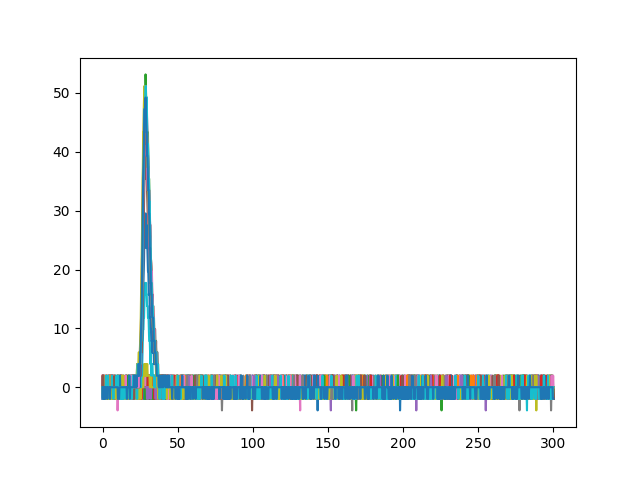

In [121]:
%matplotlib notebook

for index, row in trf_df.iterrows():
    plt.plot(row['time_ns'].tolist()[:1500], row['trf_scan'])
    plt.show()

## Visualize TRF scan set

<IPython.core.display.Javascript object>


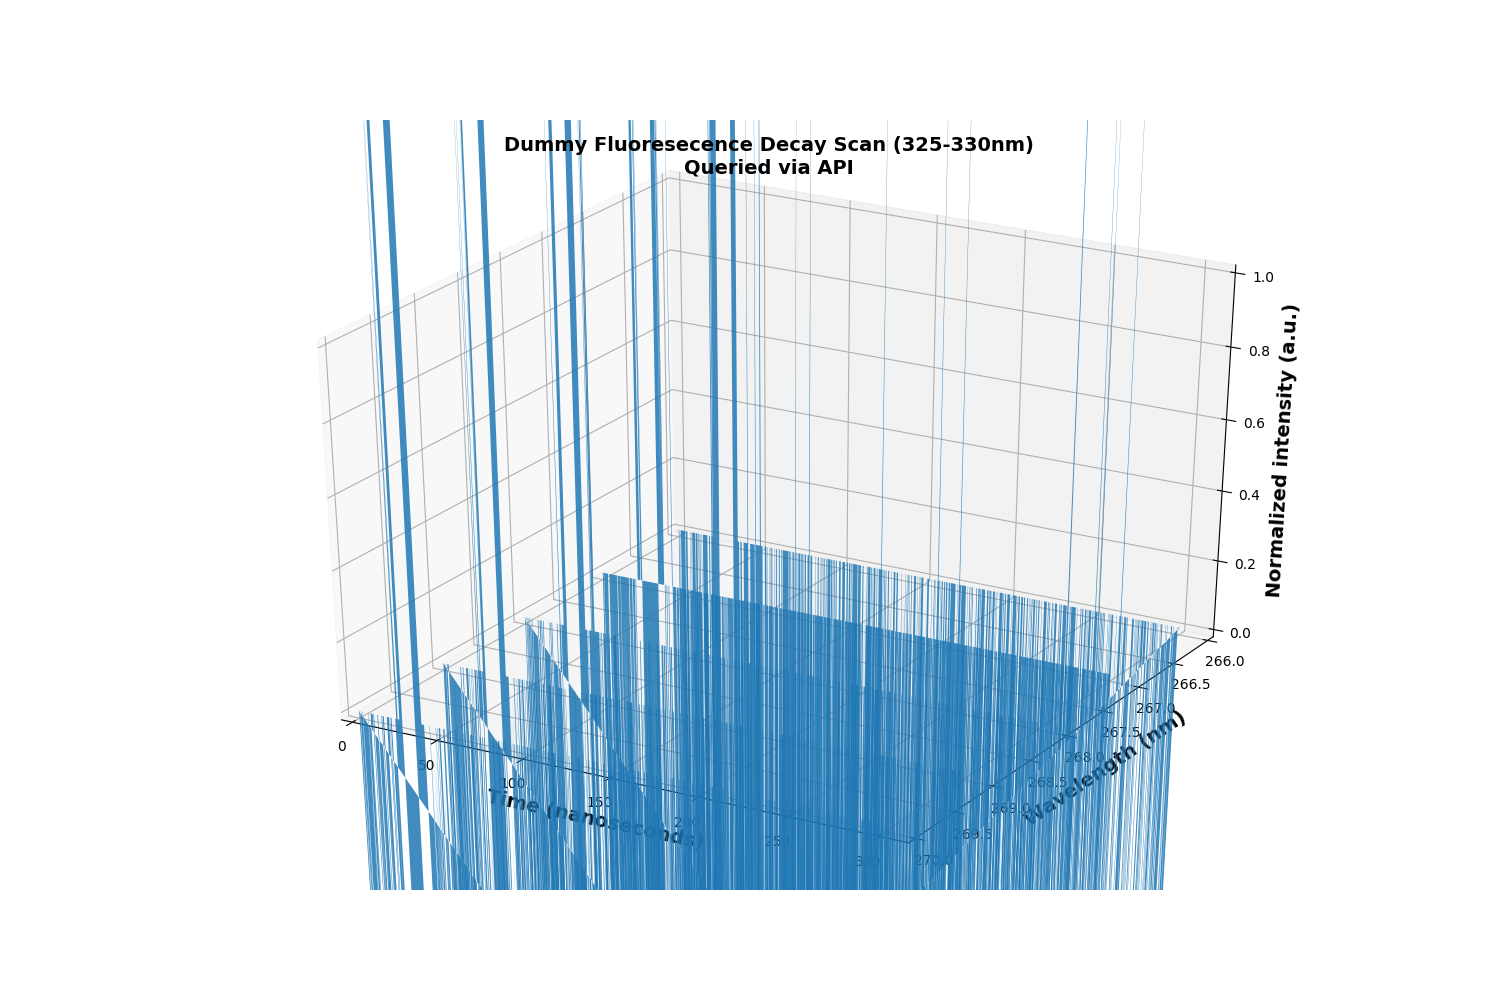

In [53]:
%matplotlib notebook

fig = plt.figure(figsize=(15,10))
ax = fig.gca(projection='3d')

xs = trf_df['time_ns'].values[0]
ys = trf_df['comb'].values.tolist()
zs = range(trf_df['mcr_wl'].min(), trf_df['mcr_wl'].max()+1)

poly = PolyCollection(ys)
poly.set_alpha(0.85)
ax.add_collection3d(poly, zs=zs, zdir='y')

ax.set_xlabel('Time (nanoseconds)', fontsize=14, fontweight="bold")
ax.set_xlim3d(xs.min(), xs.max())
ax.set_ylabel('Wavelength (nm)', fontsize=14, fontweight="bold")
ax.set_ylim3d(zs[0], zs[-1])
ax.set_zlabel('Normalized intensity (a.u.)', fontsize=14, fontweight="bold")
ax.set_zlim3d(0, 1)
title_str = "Dummy Fluoresecence Decay Scan (325-330nm)\nQueried via API"
ax.set_title(title_str, fontsize=14, fontweight="bold")

plt.show()

### `roboatenviro.RoboatEnviro.add_ssf_data(**kwargs)`

Use this method to add SSF data.

In [ ]:
ssf_df = pd.read_csv('example_qe_pro_spectrum.csv')
ssf_df.drop(columns=['LED', 'integration_time'], inplace=True)
a = ssf_df.columns
b = ssf_df.values[0]

c = list(zip(a,b))
x = [round(float(x[0]), 2) for x in c]
y = [y[1] for y in c]
ssf_df.drop(columns=a, inplace=True)
ssf_df['ssf_light_scan'] = str(b)
ssf_df['ssf_dark_scan'] = str(b)
ssf_df['em_wl'] = 405
ssf_df['ex_wl'] = 680
ssf_df['sensor_sn'] = 'SN001'
ssf_df['integ_time'] = 2000
ssf_df['scan_datetime'] = datetime.utcnow().isoformat()

display(ssf_df)

for idx, row in ssf_df.iterrows():
    params = row.to_dict()
    api.add_ssf_data(params=params)
    break

### `roboatenviro.RoboatEnviro.get_ssf_data(sn, return_type="json", final_data=True, **kwargs)`

Use this method to retrieve a list of SSF data for a given SN.

In [ ]:
ssf_df = api.get_ssf_data(sn="SN001", return_type='dataframe', params=dict(limit=1))

## Visualize SSF Scan

In [ ]:
%matplotlib inline

fig, ax = plt.subplots()
plt.plot(x,y)
ax.set_xticks(x[::-100])
ax.set_xticklabels(x[::-100], rotation=60, fontsize=12)
ax.set_xlabel('Wavelength (nm)', fontsize=20)
ax.set_ylabel('Intensity (a.u.)', fontsize=20)
ax.set_title('Dummy spectrum queried via API', fontsize=20)

plt.show()

In [ ]:
#api.delete_ssf_data()